In [2]:
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy
import json
import pandas as pd
import seaborn as sns
import sys
sys.path.append("/home/george/Dev/embeddings/")
from src.utils.misc import wordcount
from src.utils.evaluation import evaluate
from src.utils.dataloader import Dataset

from anbani.nlp.preprocessing import sentence_tokenize
sns.set_theme()


In [5]:
class GeorgianTrainer:
    def __init__(self, 
        dataset_path="/home/george/Dev/georgian-text-corpus/corpora/final/georgian_corpus_sentences.txt", 
        analogy_queries_path="../../data/kawiki/tests/questions-min-ka.txt"
    ) -> None:

        self.SET_PARAMS = {
            # TRAIN FULL DICT
            "max_final_vocab": 110_000,
            "min_count": 10,
            "seed" : 42
        }

        self.tokens = Dataset(dataset_path).load()
        _, wstats, _ = wordcount(self.tokens)
        print(wstats)
        self.analogy_queries_path = analogy_queries_path
        self.current_epoch = 0
        self.should_stop = False
        self.best_score = 0
        self.best_model = None
        self.model = None
        self.results = []


    def evaluate_model(self, model=None):
        if model == None:
            return self.model.wv.evaluate_word_analogies(self.analogy_queries_path, case_insensitive=False, restrict_vocab=1_000_000)
        return model.wv.evaluate_word_analogies(self.analogy_queries_path, case_insensitive=False, restrict_vocab=1_000_000)
            

    def train(self, params={}, callback=None, total_epochs=250):

        if self.model == None:
            self.model = FastText(
                self.tokens,
                epochs=1,
                workers=6,
                **self.SET_PARAMS,
                **params,
            )
            self.current_epoch += 1
        

        self.total_epochs = total_epochs
        pbar = tqdm(range(self.total_epochs))

        for e in pbar:
            self.model.train(self.tokens, epochs=1, total_examples=self.model.corpus_count)
            self.current_epoch += 1

            self.score, details = self.evaluate_model()
            
            self.results.append({
                "epoch": 1,
                "score": self.score,
                "params": params,
            })

            self.best_score = max(self.best_score, self.score)
            if self.score == self.best_score:
                pbar.set_description_str(
                    f"[{len(self.model.wv.key_to_index)} x {self.model.wv.vector_size}] => Best Epoch ⏳️{e}")
                self.best_model = copy.deepcopy(self.model)

            pbar.set_postfix_str(
                f"🟢 {self.best_score*100:.2f}% -> 🟡 {self.score*100:.2f}%")

            if callback: callback(self)
            if self.should_stop: break


    def plot_results(self):
        res = pd.DataFrame(self.results)
        # res.to_csv("rustaveli_word2vec_train.csv", index=None)

        print(res.iloc[0].params)
        plt.figure(figsize=(15,4), dpi=300)
        return sns.lineplot(data=res[['score']])


In [3]:
g = GeorgianTrainer()

100%|██████████| 678781/678781 [01:16<00:00, 8820.78it/s] 


{'max_group_length': 24906987, 'max_word_length': 1242, 'min_word_length': 1, 'total_words': 126290273, 'total_groups': 678781, 'total_unique_words': 2526968}


In [ ]:
g.train(
    params={
        "vector_size" : 500,
    },
    total_epochs=100
)

{'vector_size': 500}


<AxesSubplot:>

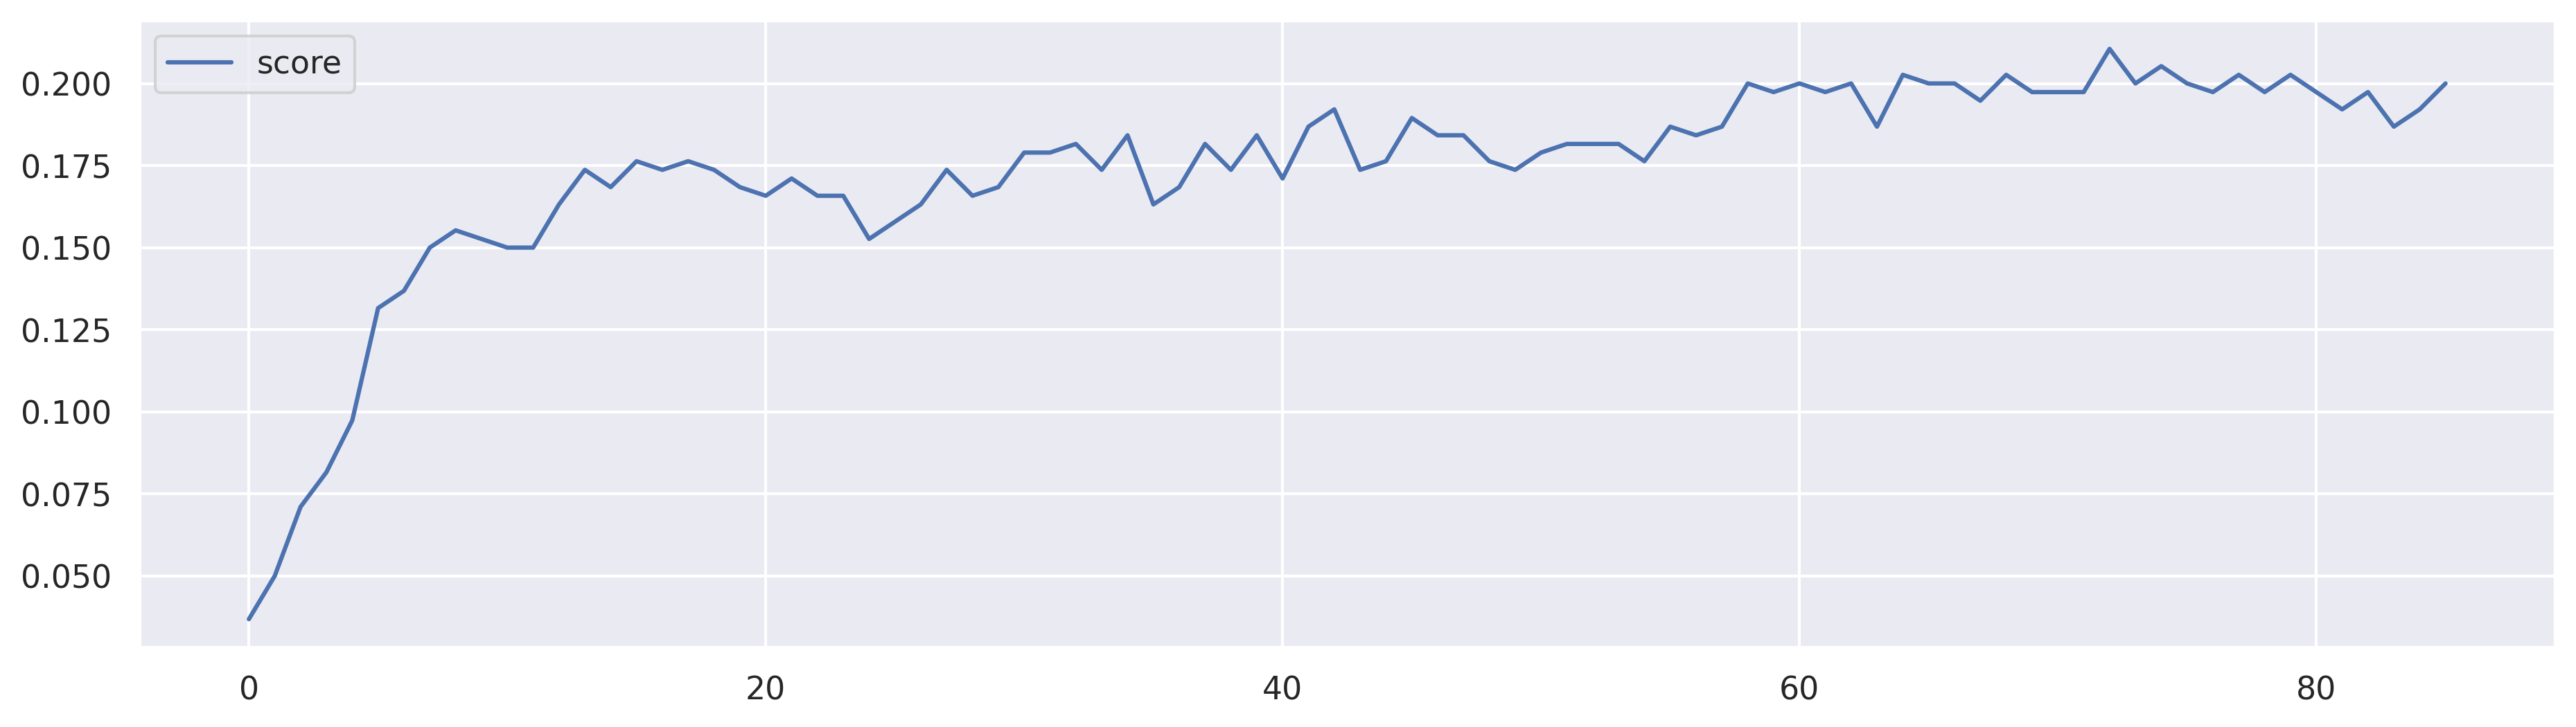

In [6]:
g.plot_results()

In [ ]:
g.evaluate_model()

In [5]:
g.best_model.save('georgian_fasttext_110K_500D_72e.model')

In [10]:
from projector import generate_tensors

generate_tensors(g.best_model, "ქართული ენის კორპუსი")

100%|██████████| 109329/109329 [00:30<00:00, 3583.59it/s, ჩვევათა]             




{
    "embeddings": [
      {
        "tensorName": ქართული ენის კორპუსი,
        "tensorShape": [109329, 500],
        "tensorPath": "../../artifacts/web/ქართული ენის კორპუსი_tensors.bytes",
        "metadataPath": "../../artifacts/web/ქართული ენის კორპუსი_labels.tsv"
      }
    ],
  }


In [11]:
g.best_model.wv.save_word2vec_format("georgian_fasttext_110K_500D_72e.txt", binary=False)